In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import warnings

# Cấu hình hiển thị
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully.")

Libraries imported successfully.


In [17]:
# ==========================================
# CẤU HÌNH INPUT (THAY ĐỔI CHO DATASET 2 HOẶC 3)
# ==========================================
AUDIO_ROOT = './data3'  # Thay bằng './data3' khi chạy cho dataset 3
DATASET_NAME = "Dataset 3" # Tên dùng để in báo cáo
SAMPLE_RATE_TARGET = 16000
AUDIO_EXT = ('.wav', '.mp3', '.flac', '.ogg')

# ==========================================
# HÀM XỬ LÝ
# ==========================================

def scan_folder_structure(root_path):
    """
    Quét cấu trúc thư mục: Label/File.mp3
    Trả về DataFrame: file_path, label
    """
    data = []
    root = Path(root_path)
    
    if not root.exists():
        print(f"❌ Lỗi: Thư mục '{root_path}' không tồn tại.")
        return pd.DataFrame()

    # Duyệt qua các thư mục con (Label)
    for label_dir in root.iterdir():
        if label_dir.is_dir():
            label_name = label_dir.name
            # Duyệt file audio trong thư mục label
            for file in label_dir.iterdir():
                if file.suffix.lower() in AUDIO_EXT:
                    data.append({
                        'file_path': str(file),
                        'label': label_name
                    })
    
    return pd.DataFrame(data)

def extract_audio_features(row):
    """
    Trích xuất Duration, RMS, SR, n_samples.
    Dùng cho bước II. Thống kê đặc thù.
    """
    path = row['file_path']
    try:
        # Load audio (lấy SR gốc để kiểm tra)
        y, sr = librosa.load(path, sr=None, mono=True)
        
        # Tính Duration
        duration = librosa.get_duration(y=y, sr=sr)
        
        # Tính RMS (Root Mean Square - Năng lượng)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms) if len(rms) > 0 else 0
        
        return pd.Series({
            'duration': duration,
            'rms_mean': rms_mean,
            'sr': sr,
            'n_samples': len(y),
            'read_ok': True,
            'error_msg': None
        })
    except Exception as e:
        return pd.Series({
            'duration': 0,
            'rms_mean': 0,
            'sr': 0,
            'n_samples': 0,
            'read_ok': False,
            'error_msg': str(e)
        })

print(f"Pipeline setup complete for {AUDIO_ROOT}")

Pipeline setup complete for ./data3


In [18]:
print(f"\n=== II. THỐNG KÊ MÔ TẢ & ĐẶC THÙ AUDIO ({DATASET_NAME}) ===")
print("(Đang đọc file audio để trích xuất đặc trưng... Vui lòng đợi)")

if len(df) > 0:
    # Trích xuất đặc trưng audio (Duration, RMS, SR, n_samples)
    audio_stats = df.apply(extract_audio_features, axis=1)
    
    # Gộp vào DataFrame chính
    df_full = pd.concat([df, audio_stats], axis=1)
    
    # Chỉ lấy các file đọc thành công
    df_valid = df_full[df_full['read_ok'] == True].copy()
    
    # --- Lọc audio 0.5 ≤ duration ≤ 15 giây ---
    MIN_DURATION = 0.5
    MAX_DURATION = 15.0
    df_valid = df_valid[(df_valid['duration'] >= MIN_DURATION) & (df_valid['duration'] <= MAX_DURATION)]
    df_valid = df_valid.reset_index(drop=True)
    
    print(f"\n► Sau khi lọc file {MIN_DURATION}-{MAX_DURATION}s, còn lại {len(df_valid)} file")
    
    # --- 2.1 Thống kê cơ bản ---
    print(f"\n[2.1 Thống kê cơ bản]")
    print(f"- Tổng số mẫu (Samples): {len(df_valid)}")
    print(f"- Số thuộc tính (Columns): {df_valid.shape[1]}")
    
    # --- 2.2 Thống kê đặc thù Audio ---
    print(f"\n[2.2 Thống kê đặc thù Audio]")
    
    # Thống kê Duration
    desc_dur = df_valid['duration'].describe()
    var_dur = df_valid['duration'].var()
    iqr_dur = desc_dur['75%'] - desc_dur['25%']
    
    print(f"\n>>> Duration (Thời lượng):")
    print(f"  Mean: {desc_dur['mean']:.2f} s")
    print(f"  Median: {desc_dur['50%']:.2f} s")
    print(f"  Min / Max: {desc_dur['min']:.2f} / {desc_dur['max']:.2f} s")
    print(f"  Variance: {var_dur:.2f}")
    print(f"  IQR: {iqr_dur:.2f}")
    
    # Thống kê RMS
    desc_rms = df_valid['rms_mean'].describe()
    var_rms = df_valid['rms_mean'].var()
    
    print(f"\n>>> RMS (Cường độ):")
    print(f"  Mean: {desc_rms['mean']:.4f}")
    print(f"  Median: {desc_rms['50%']:.4f}")
    print(f"  Variance: {var_rms:.6f}")
    
    # Kiểm tra chuẩn Frequency
    print(f"\n>>> Sample Rate (Tần số):")
    wrong_sr_count = df_valid[df_valid['sr'] != SAMPLE_RATE_TARGET].shape[0]
    print(f"  Chuẩn yêu cầu: {SAMPLE_RATE_TARGET} Hz")
    print(f"  Số file sai chuẩn: {wrong_sr_count} file")
    if wrong_sr_count > 0:
        print("  Kế hoạch: Cần Resample về 16,000 Hz.")
    else:
        print("  Kế hoạch: Dữ liệu đã đồng nhất.")



=== II. THỐNG KÊ MÔ TẢ & ĐẶC THÙ AUDIO (Dataset 3) ===
(Đang đọc file audio để trích xuất đặc trưng... Vui lòng đợi)

► Sau khi lọc file 0.5-15.0s, còn lại 99 file

[2.1 Thống kê cơ bản]
- Tổng số mẫu (Samples): 99
- Số thuộc tính (Columns): 9

[2.2 Thống kê đặc thù Audio]

>>> Duration (Thời lượng):
  Mean: 6.01 s
  Median: 5.54 s
  Min / Max: 0.98 / 14.40 s
  Variance: 9.93
  IQR: 4.21

>>> RMS (Cường độ):
  Mean: 0.0571
  Median: 0.0406
  Variance: 0.002110

>>> Sample Rate (Tần số):
  Chuẩn yêu cầu: 16000 Hz
  Số file sai chuẩn: 99 file
  Kế hoạch: Cần Resample về 16,000 Hz.


In [19]:
print(f"\n=== I. QUY TRÌNH LÀM SẠCH & SƠ CHẾ ({DATASET_NAME}) ===")

# 1. Load dữ liệu thô
df = scan_folder_structure(AUDIO_ROOT)
print(f"-> Tổng số file quét được: {len(df)}")

if len(df) > 0:
    # 2. Chuẩn hóa định dạng (Normalization)
    # Chuyển nhãn về chữ thường, xóa khoảng trắng
    df['label_clean'] = df['label'].astype(str).str.lower().str.strip()
    print(f"-> Label gốc: {df['label'].unique()}")
    print(f"-> Label chuẩn hóa: {df['label_clean'].unique()}")

    # 3. Loại bỏ trùng lặp metadata (Duplicate paths)
    n_dups = df.duplicated(subset=['file_path']).sum()
    if n_dups > 0:
        print(f"-> Phát hiện {n_dups} dòng trùng lặp. Đang loại bỏ...")
        df = df.drop_duplicates(subset=['file_path'])
    else:
        print("-> Không có file trùng lặp đường dẫn.")

    # 4. Kiểm tra dữ liệu thiếu (Missing Metadata)
    missing = df.isnull().sum().sum()
    print(f"-> Tổng số giá trị thiếu trong metadata: {missing}")
else:
    print("⚠️ Cảnh báo: Không tìm thấy dữ liệu!")


=== I. QUY TRÌNH LÀM SẠCH & SƠ CHẾ (Dataset 3) ===
-> Tổng số file quét được: 160
-> Label gốc: ['Angry' 'Happy' 'Neutral' 'Sad']
-> Label chuẩn hóa: ['angry' 'happy' 'neutral' 'sad']
-> Không có file trùng lặp đường dẫn.
-> Tổng số giá trị thiếu trong metadata: 0


In [20]:
print(f"\n=== II. THỐNG KÊ MÔ TẢ & ĐẶC THÙ AUDIO ({DATASET_NAME}) ===")
print("(Đang đọc file audio để trích xuất đặc trưng... Vui lòng đợi)")

if len(df) > 0:
    # Áp dụng hàm trích xuất đặc trưng (có thể dùng tqdm để hiện thanh tiến trình nếu muốn)
    audio_stats = df.apply(extract_audio_features, axis=1)
    
    # Gộp vào dataframe chính
    df_full = pd.concat([df, audio_stats], axis=1)
    
    # Chỉ lấy các file đọc thành công để thống kê
    df_valid = df_full[df_full['read_ok'] == True]
    
    # --- 2.1 Thống kê cơ bản ---
    print(f"\n[2.1 Thống kê cơ bản]")
    print(f"- Tổng số mẫu (Samples): {len(df_full)}")
    print(f"- Số thuộc tính (Columns): {df_full.shape[1]}")
    
    # --- 2.2 Thống kê đặc thù Audio ---
    print(f"\n[2.2 Thống kê đặc thù Audio]")
    
    # Thống kê Duration
    desc_dur = df_valid['duration'].describe()
    var_dur = df_valid['duration'].var()
    iqr_dur = desc_dur['75%'] - desc_dur['25%']
    
    print(f"\n>>> Duration (Thời lượng):")
    print(f"  Mean: {desc_dur['mean']:.2f} s")
    print(f"  Median: {desc_dur['50%']:.2f} s")
    print(f"  Min / Max: {desc_dur['min']:.2f} / {desc_dur['max']:.2f} s")
    print(f"  Variance: {var_dur:.2f}")
    print(f"  IQR: {iqr_dur:.2f}")
    
    # Thống kê RMS
    desc_rms = df_valid['rms_mean'].describe()
    var_rms = df_valid['rms_mean'].var()
    
    print(f"\n>>> RMS (Cường độ):")
    print(f"  Mean: {desc_rms['mean']:.4f}")
    print(f"  Median: {desc_rms['50%']:.4f}")
    print(f"  Variance: {var_rms:.6f}")
    
    # Kiểm tra chuẩn Frequency
    print(f"\n>>> Sample Rate (Tần số):")
    wrong_sr_count = df_valid[df_valid['sr'] != SAMPLE_RATE_TARGET].shape[0]
    print(f"  Chuẩn yêu cầu: {SAMPLE_RATE_TARGET} Hz")
    print(f"  Số file sai chuẩn: {wrong_sr_count} file")
    if wrong_sr_count > 0:
        print("  Kế hoạch: Cần Resample về 16,000 Hz.")
    else:
        print("  Kế hoạch: Dữ liệu đã đồng nhất.")


=== II. THỐNG KÊ MÔ TẢ & ĐẶC THÙ AUDIO (Dataset 3) ===
(Đang đọc file audio để trích xuất đặc trưng... Vui lòng đợi)

[2.1 Thống kê cơ bản]
- Tổng số mẫu (Samples): 160
- Số thuộc tính (Columns): 9

[2.2 Thống kê đặc thù Audio]

>>> Duration (Thời lượng):
  Mean: 7.87 s
  Median: 5.86 s
  Min / Max: 0.05 / 57.97 s
  Variance: 54.70
  IQR: 5.80

>>> RMS (Cường độ):
  Mean: 0.0603
  Median: 0.0442
  Variance: 0.002222

>>> Sample Rate (Tần số):
  Chuẩn yêu cầu: 16000 Hz
  Số file sai chuẩn: 112 file
  Kế hoạch: Cần Resample về 16,000 Hz.


In [21]:
df.head()

,file_path,label,label_clean
0,data3\Angry\Angry_Cua lại vợ bầu_1.mp3,Angry,angry
1,data3\Angry\Angry_Cua lại vợ bầu_2.mp3,Angry,angry
2,data3\Angry\Angry_Gia đình mình vui bất thình ...,Angry,angry
3,data3\Angry\Angry_Gia đình mình vui bất thình ...,Angry,angry
4,data3\Angry\Angry_Gia đình mình vui bất thình ...,Angry,angry


In [22]:
print(f"\n=== III. PHÂN TÍCH PHÂN BỐ NHÃN ({DATASET_NAME}) ===")

if len(df) > 0:
    # 3.1 Kiểm tra mất cân bằng
    label_counts = df['label_clean'].value_counts()
    label_percents = df['label_clean'].value_counts(normalize=True) * 100
    
    print("\n[3.1 Tỉ lệ phần trăm các lớp]")
    print(label_percents)
    
    # Đánh giá sơ bộ
    max_ratio = label_counts.max() / label_counts.min()
    print(f"\nMax/Min Ratio: {max_ratio:.2f}")
    
    if max_ratio > 2.0:
        print("-> Đánh giá: Mất cân bằng dữ liệu NẶNG.")
        print("-> Phương án 3.2: Cần Oversampling (SMOTE) hoặc dùng Class-weight.")
    elif max_ratio > 1.2:
        print("-> Đánh giá: Mất cân bằng dữ liệu NHẸ.")
    else:
        print("-> Đánh giá: Dữ liệu cân bằng tốt.")


=== III. PHÂN TÍCH PHÂN BỐ NHÃN (Dataset 3) ===

[3.1 Tỉ lệ phần trăm các lớp]
label_clean
neutral    31.25
angry      26.25
sad        25.00
happy      17.50
Name: proportion, dtype: float64

Max/Min Ratio: 1.79
-> Đánh giá: Mất cân bằng dữ liệu NHẸ.



=== IV. TRỰC QUAN ĐƠN BIẾN (Dataset 3) ===
► Hiển thị các file audio từ 0.5 đến 15.0s, tổng 99 file


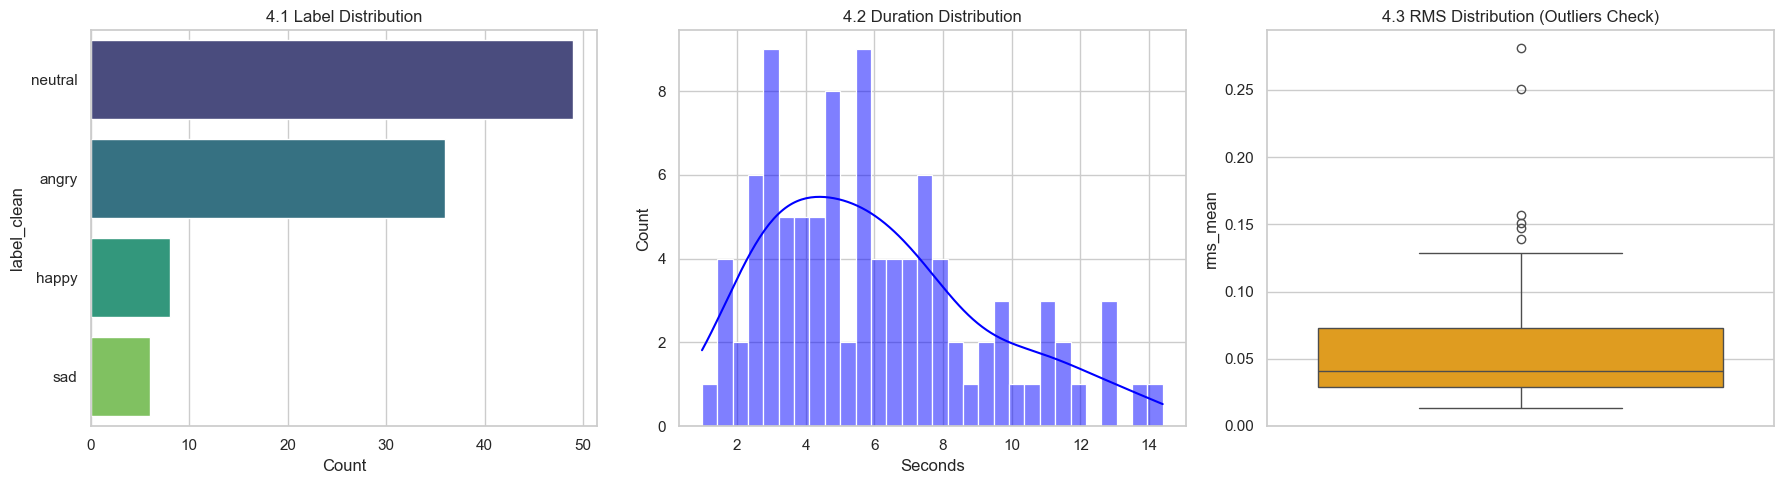

Nhận xét Outliers Duration: Có 0 file dài bất thường (> 15.46s).


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\n=== IV. TRỰC QUAN ĐƠN BIẾN ({DATASET_NAME}) ===")

if len(df_valid) > 0:
    # Lọc file audio trong khoảng 0.5 → 15 giây
    MIN_DURATION = 0.5
    MAX_DURATION = 15.0
    df_plot = df_valid[(df_valid['duration'] >= MIN_DURATION) & (df_valid['duration'] <= MAX_DURATION)].copy()
    
    print(f"► Hiển thị các file audio từ {MIN_DURATION} đến {MAX_DURATION}s, tổng {len(df_plot)} file")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 4.1 Phân bố Nhãn
    sns.countplot(y=df_plot['label_clean'], ax=axes[0], 
                  order=df_plot['label_clean'].value_counts().index, palette='viridis')
    axes[0].set_title('4.1 Label Distribution')
    axes[0].set_xlabel('Count')
    
    # 4.2 Phân bố Duration (Histogram)
    sns.histplot(df_plot['duration'], kde=True, ax=axes[1], color='blue', bins=30)
    axes[1].set_title('4.2 Duration Distribution')
    axes[1].set_xlabel('Seconds')
    
    # 4.3 Phân bố RMS (Boxplot)
    sns.boxplot(y=df_plot['rms_mean'], ax=axes[2], color='orange')
    axes[2].set_title('4.3 RMS Distribution (Outliers Check)')
    
    plt.tight_layout()
    plt.show()
    
    # Kiểm tra Outliers Duration (> Mean + 3*STD)
    mean_dur = df_plot['duration'].mean()
    std_dur = df_plot['duration'].std()
    outliers = df_plot[df_plot['duration'] > mean_dur + 3*std_dur]
    print(f"Nhận xét Outliers Duration: Có {len(outliers)} file dài bất thường (> {mean_dur + 3*std_dur:.2f}s).")



=== V. TRỰC QUAN ĐA BIẾN (Dataset 3) ===


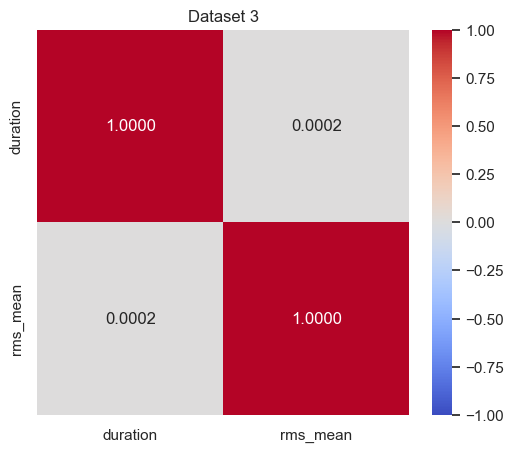

-> Hệ số tương quan Pearson (Duration vs RMS): r = 0.0002

[5.2 Kết quả kiểm tra VIF]
    Feature       VIF
0  duration  1.497678
1  rms_mean  1.497678
-> Kết luận: Không có hiện tượng đa cộng tuyến (VIF < 5).


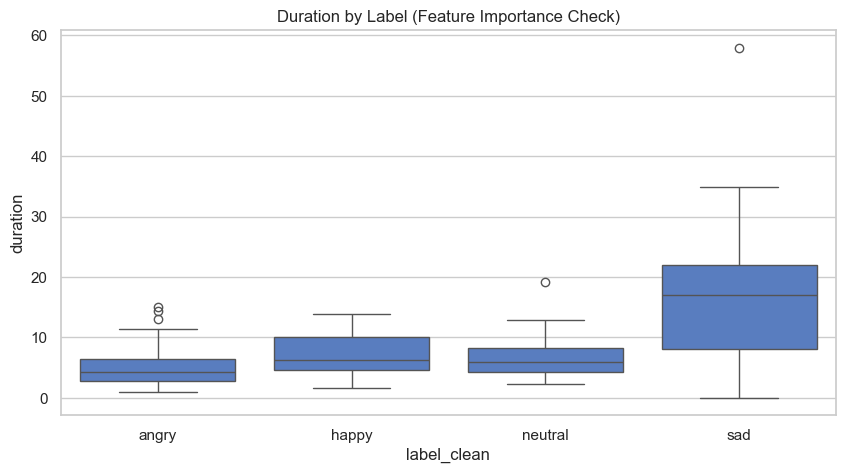

In [24]:
print(f"\n=== V. TRỰC QUAN ĐA BIẾN ({DATASET_NAME}) ===")

if len(df_valid) > 0:
    # 5.1 Tương quan biến số (Heatmap)
    cols_corr = ['duration', 'rms_mean']
    corr_matrix = df_valid[cols_corr].corr()
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Dataset 3')
    plt.show()
    
    # Hệ số tương quan Pearson Duration vs RMS
    r_pearson = df_valid['duration'].corr(df_valid['rms_mean'])
    print(f"-> Hệ số tương quan Pearson (Duration vs RMS): r = {r_pearson:.4f}")
    
    # 5.2 Phân tích Đa cộng tuyến (VIF)
    # Chỉ tính VIF cho Duration và RMS (các biến input tiềm năng)
    X_vif = df_valid[['duration', 'rms_mean']].dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    print("\n[5.2 Kết quả kiểm tra VIF]")
    print(vif_data)
    
    if vif_data['VIF'].max() < 5:
        print("-> Kết luận: Không có hiện tượng đa cộng tuyến (VIF < 5).")
    else:
        print("-> Kết luận: Có khả năng đa cộng tuyến.")

    # 5.3 Đánh giá biến quan trọng (Boxplot theo Label)
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_valid, x='label_clean', y='duration')
    plt.title('Duration by Label (Feature Importance Check)')
    plt.show()

In [25]:
print(f"\n=== VI. KIỂM TRA CHẤT LƯỢNG DỮ LIỆU ({DATASET_NAME}) ===")

if len(df_full) > 0:
    # Tổng hợp lỗi
    missing_val = df_full.isnull().sum().sum()
    dup_rows = df.duplicated().sum()
    file_error = df_full[df_full['read_ok'] == False].shape[0]
    audio_mute = df_full[(df_full['read_ok'] == True) & (df_full['rms_mean'] == 0)].shape[0]
    
    # Tạo bảng báo cáo (giả lập format bảng)
    print(f"{'Loại lỗi':<25} | {'Số lượng':<10} | {'Mức độ'}")
    print("-" * 50)
    print(f"{'Missing Value':<25} | {missing_val:<10} | Thấp")
    print(f"{'Duplicate Rows':<25} | {dup_rows:<10} | Thấp")
    print(f"{'File lỗi (Read Error)':<25} | {file_error:<10} | Cao")
    print(f"{'Audio câm (RMS=0)':<25} | {audio_mute:<10} | Cao")
    
    print("\n[Kế hoạch khắc phục đề xuất]:")
    print("- Xóa bỏ toàn bộ file lỗi, file câm.")
    print(f"- Resample {wrong_sr_count} file sai tần số về {SAMPLE_RATE_TARGET}Hz.")


=== VI. KIỂM TRA CHẤT LƯỢNG DỮ LIỆU (Dataset 3) ===
Loại lỗi                  | Số lượng   | Mức độ
--------------------------------------------------
Missing Value             | 112        | Thấp
Duplicate Rows            | 0          | Thấp
File lỗi (Read Error)     | 48         | Cao
Audio câm (RMS=0)         | 0          | Cao

[Kế hoạch khắc phục đề xuất]:
- Xóa bỏ toàn bộ file lỗi, file câm.
- Resample 112 file sai tần số về 16000Hz.



=== VII. EDA DỮ LIỆU PHI CẤU TRÚC (Dataset 3) ===


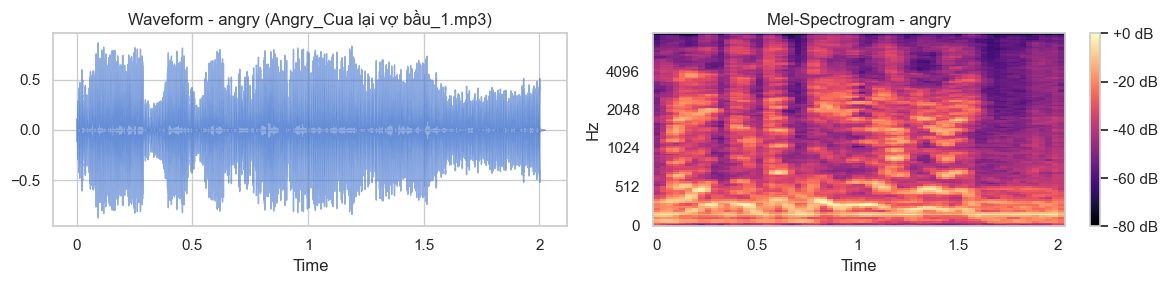

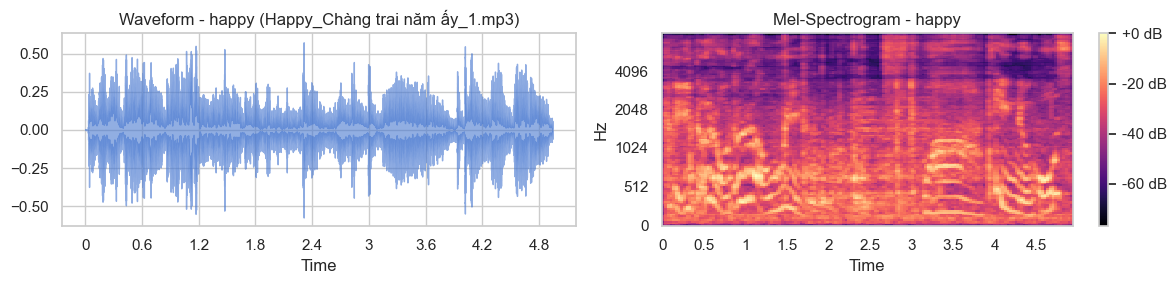

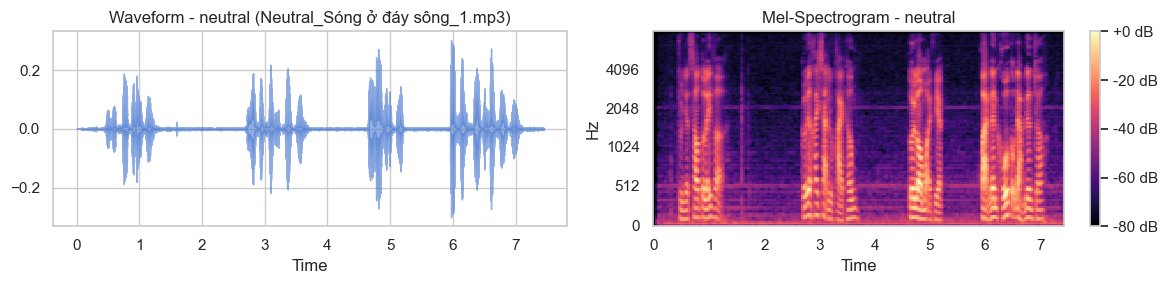

In [26]:
print(f"\n=== VII. EDA DỮ LIỆU PHI CẤU TRÚC ({DATASET_NAME}) ===")

# Lấy 1 file mẫu từ mỗi nhãn (tối đa 3 nhãn để demo)
if len(df_valid) > 0:
    sample_labels = df_valid['label_clean'].unique()[:3] 
    
    for lbl in sample_labels:
        sample_row = df_valid[df_valid['label_clean'] == lbl].iloc[0]
        path = sample_row['file_path']
        
        y, sr = librosa.load(path, sr=SAMPLE_RATE_TARGET)
        
        plt.figure(figsize=(12, 3))
        
        # Waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.title(f"Waveform - {lbl} ({os.path.basename(path)})")
        
        # Mel-Spectrogram
        plt.subplot(1, 2, 2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr)
        plt.colorbar(img, format='%+2.0f dB')
        plt.title(f"Mel-Spectrogram - {lbl}")
        
        plt.tight_layout()
        plt.show()

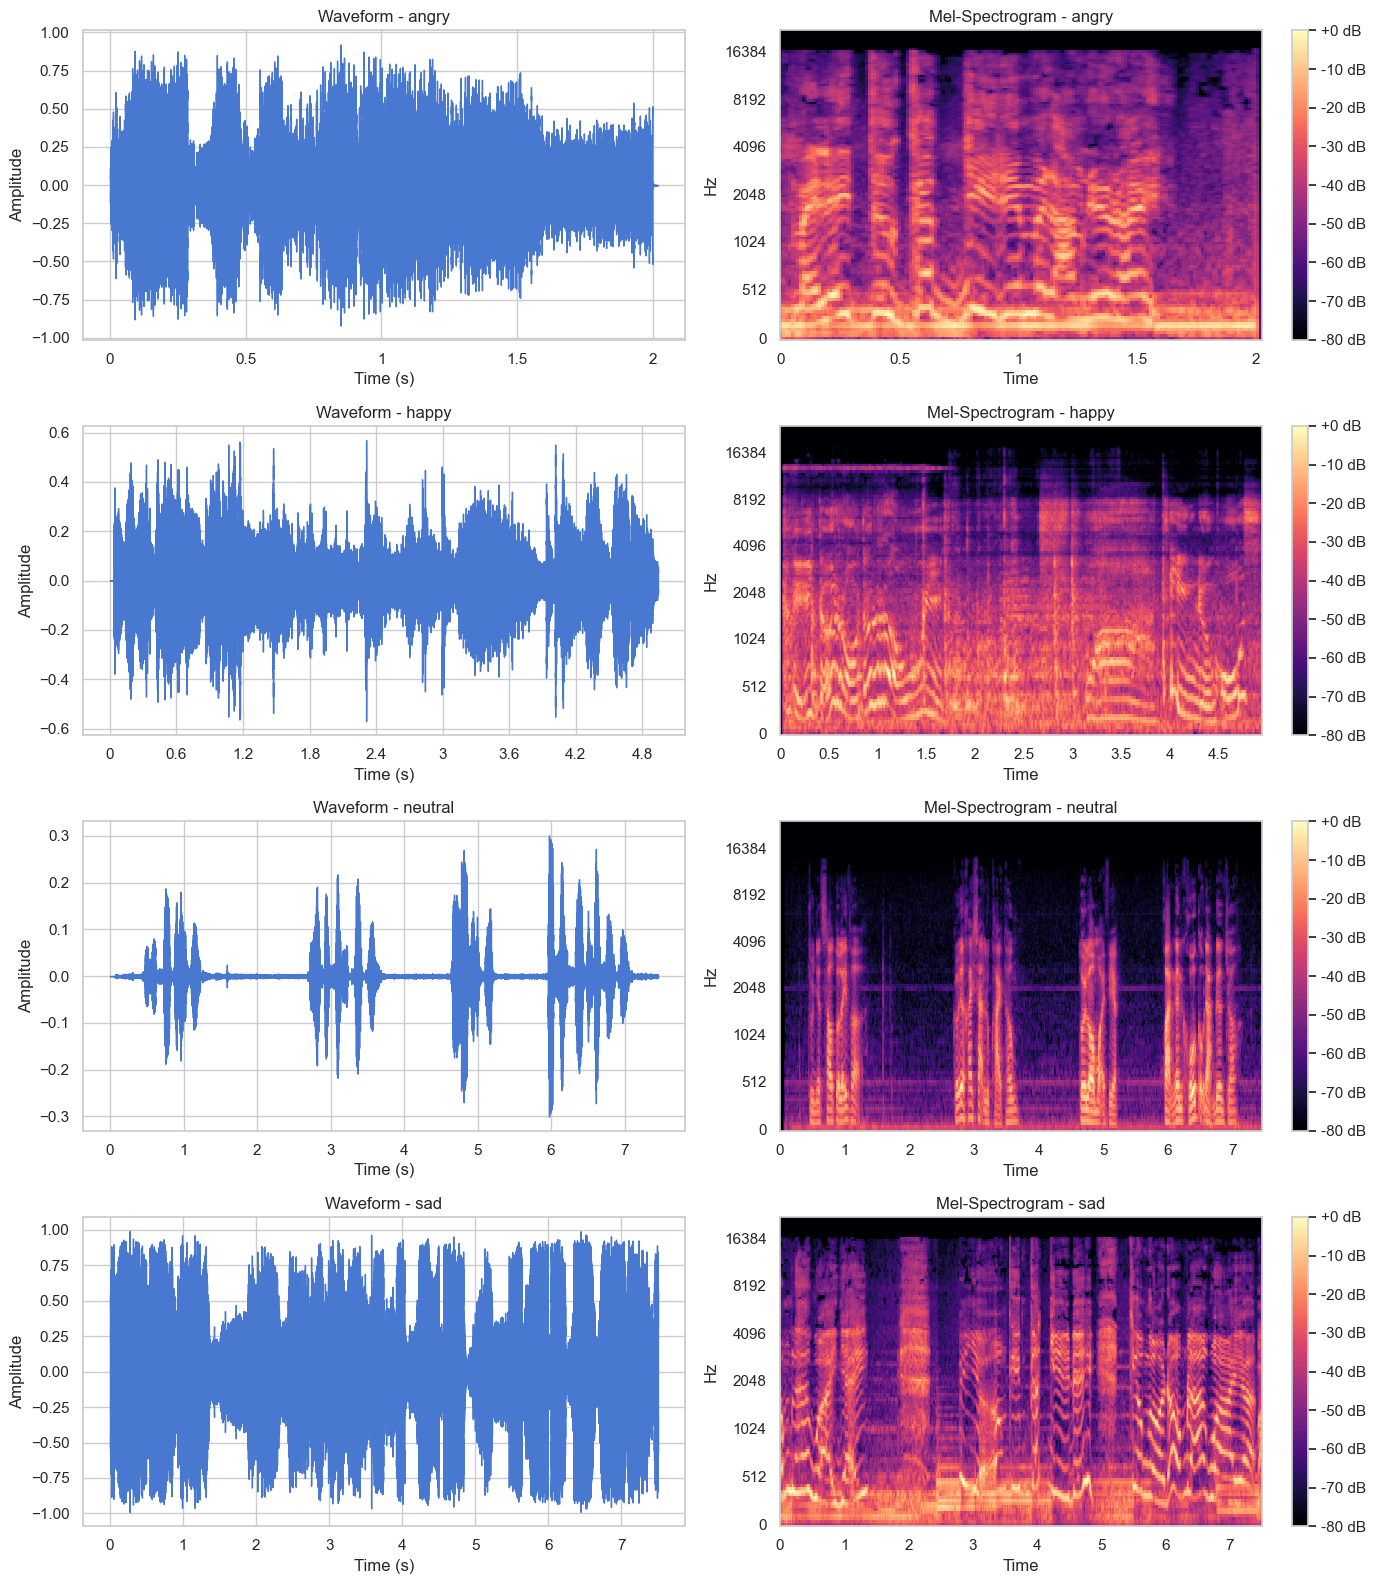

In [27]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset2_stacked(df_valid, duration_min=1.0, duration_max=15.0, num_labels=4):
    """
    Visualize stacked waveform and spectrogram for multiple labels (1 row per label).
    Only selects audio between duration_min and duration_max (seconds).
    """
    sample_labels = df_valid['label_clean'].unique()[:num_labels]
    
    # Chọn sample trong khoảng thời lượng
    selected_samples = []
    for lbl in sample_labels:
        candidates = df_valid[df_valid['label_clean'] == lbl]
        for idx, row in candidates.iterrows():
            y, sr = librosa.load(row['file_path'], sr=None)
            dur = librosa.get_duration(y=y, sr=sr)
            if duration_min <= dur <= duration_max:
                selected_samples.append((lbl, row['file_path'], y, sr))
                break  # chỉ lấy 1 file/nghãn
    
    num_samples = len(selected_samples)
    if num_samples == 0:
        print("⚠️ Không có sample nào phù hợp khoảng thời lượng")
        return
    
    plt.figure(figsize=(14, 4*num_samples))
    
    for i, (lbl, path, y, sr) in enumerate(selected_samples):
        # Waveform
        plt.subplot(num_samples, 2, 2*i+1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform - {lbl}')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        # Spectrogram
        plt.subplot(num_samples, 2, 2*i+2)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram - {lbl}')
    
    plt.tight_layout()
    plt.show()

# Gọi hàm
visualize_dataset2_stacked(df_valid)


In [28]:
print(f"\n=== VIII. KẾT LUẬN EDA ({DATASET_NAME}) ===")
print("1. Tóm tắt:")
print(f"   - Dữ liệu hiện tại có {len(df_valid)} mẫu hợp lệ.")
if max_ratio > 1.5:
    print(f"   - Vấn đề chính: Mất cân bằng dữ liệu (Ratio {max_ratio:.2f}).")
else:
    print(f"   - Dữ liệu phân bố khá đồng đều.")

print("2. Biến số quan trọng:")
print("   - Mel-Spectrogram sẽ là đặc trưng đầu vào chính.")
print(f"   - RMS (Mean={desc_rms['mean']:.3f}) có thể dùng làm đặc trưng bổ sung.")

print("3. Khuyến nghị cho Train:")
print("   - Cần Resample toàn bộ về 16kHz.")
print(f"   - Nên padding/truncate audio về độ dài khoảng {desc_dur['50%']:.2f}s (Median).")
if max_ratio > 1.5:
    print("   - Áp dụng Data Augmentation (Pitch shift, Noise) cho các lớp thiểu số.")


=== VIII. KẾT LUẬN EDA (Dataset 3) ===
1. Tóm tắt:
   - Dữ liệu hiện tại có 112 mẫu hợp lệ.
   - Vấn đề chính: Mất cân bằng dữ liệu (Ratio 1.79).
2. Biến số quan trọng:
   - Mel-Spectrogram sẽ là đặc trưng đầu vào chính.
   - RMS (Mean=0.060) có thể dùng làm đặc trưng bổ sung.
3. Khuyến nghị cho Train:
   - Cần Resample toàn bộ về 16kHz.
   - Nên padding/truncate audio về độ dài khoảng 5.86s (Median).
   - Áp dụng Data Augmentation (Pitch shift, Noise) cho các lớp thiểu số.
